A **Double DQN (DDQN)** implementation in tensorflow with random experience replay.

Environment from openai gym: CartPole-v0

---
<br>
**Notations**

Model network = $Q_{\theta}$ \
Model parameter = $\theta$ \\
Model network Q value = $Q_{\theta}$ (s, a) \
<br>
Target network = $Q_{\phi}$ \
Target parameter = $\phi$ \
Target network Q value = $Q_{\phi}$ ($s^{'}$, $a^{'}$) \

---
<br>
**Equations**

TD target = r (s, a) $+$ $\gamma$ $Q_{\phi}$ ($s^{'}$, $argmax_{a^{'}}$ $Q_{\theta}$ (s$^{'}$, a$^{'}$)) \
<br>
TD  error = (TD target) $-$ (Model network Q value) \
$\hspace{26pt}$ 
= [r (s, a) $+$ $\gamma$ $Q_{\phi}$ ($s^{'}$, $argmax_{a^{'}}$ $Q_{\theta}$ (s$^{'}$, a$^{'}$))] $-$ $Q_{\theta}$ (s, a) \

---
<br>
**Implementation details**

Create a placeholder to feed Q values from model network: \
>![alt text](https://drive.google.com/uc?export=view&id=1CcZVw82JRQRWYmTFFN9PvLKjd4b5BOAF)

Select Q values from model network using $s^{'}$ as features & feed them to the training session: \
>![alt text](https://drive.google.com/uc?export=view&id=15uOc3uOz83V76X5s3PmgzzVWYJkkwR0Z)

Select minibatch actions with largest Q values from model network, create indices & select corresponding minibatch actions from target network: \
>![alt text](https://drive.google.com/uc?export=view&id=1YelpKjS68nPBWtg8oeLiZV4mpzkmTPT_)

---
<br>
**References**

[Deep Reinforcement Learning with Double Q-learning
(Hasselt, Guez & Silver, 2016)](https://arxiv.org/pdf/1509.06461.pdf)


In [0]:
import tensorflow as tf
import gym
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# random sampling for learning from experience replay
class Exp():
    def __init__(self, obs_size, max_size):
        self.obs_size = obs_size
        self.num_obs = 0
        self.max_size = max_size
        self.mem_full = False
        
        # memory structure that stores samples from observations
        self.mem = {'s'        : np.zeros(self.max_size * self.obs_size, dtype=np.float32).reshape(self.max_size,self.obs_size),
                    'a'        : np.zeros(self.max_size * 1, dtype=np.int32).reshape(self.max_size,1),
                    'r'        : np.zeros(self.max_size * 1).reshape(self.max_size,1),
                    'done'     : np.zeros(self.max_size * 1, dtype=np.int32).reshape(self.max_size,1)}

    # stores sample obervation at each time step in experience memory
    def store(self, s, a, r, done):
        i = self.num_obs % self.max_size
        
        self.mem['s'][i,:] = s
        self.mem['a'][i,:] = a
        self.mem['r'][i,:] = r
        self.mem['done'][i,:] = done
        
        self.num_obs += 1
        
        if self.num_obs == self.max_size:
            self.num_obs = 0 # reset number of observation
            self.mem_full = True

    # returns a minibatch of experience
    def minibatch(self, minibatch_size):
        if self.mem_full == False:
            max_i = min(self.num_obs, self.max_size) - 1
        else:
            max_i = self.max_size - 1
        
        # randomly sample a minibatch of indexes
        sampled_i = np.random.randint(max_i, size=minibatch_size)      
                
        s      = self.mem['s'][sampled_i,:].reshape(minibatch_size, self.obs_size)
        a      = self.mem['a'][sampled_i].reshape(minibatch_size)
        r      = self.mem['r'][sampled_i].reshape((minibatch_size,1))
        s_next = self.mem['s'][sampled_i + 1,:].reshape(minibatch_size, self.obs_size)
        done   = self.mem['done'][sampled_i].reshape((minibatch_size,1))
        
        return (s, a, r, s_next, done)

In [0]:
# Evaluates behavior policy while improving target policy
class DDQN_agent():
    def __init__(self, num_actions, obs_size, nhidden,
                 epoch, 
                 epsilon, gamma, learning_rate, 
                 replace, polyak, tau_step,
                 mem_size, minibatch_size):
        super(DDQN_agent, self).__init__()
        
        self.actions = range(num_actions)
        self.num_actions = num_actions
        self.obs_size = obs_size # number of features
        self.nhidden = nhidden # hidden nodes
        
        self.epoch = epoch # for epsilon decay & to decide when to start training

        self.epsilon = epsilon # for eploration
        self.gamma = gamma # discount factor
        self.learning_rate = learning_rate # learning rate alpha
        
        # for params replacement
        self.replace = replace # type of replacement
        self.polyak = polyak # for soft replacement
        self.tau_step = tau_step # for hard replacement
        self.learn_step = 0 # steps after learning
        
        # for Experience replay
        self.mem = Exp(self.obs_size, mem_size) # memory that holds experiences
        self.minibatch_size = minibatch_size
        
        self.step = 0 # each step in a episode
                
        # for tensorflow ops
        self.built_graph()        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.target_replace_hard)
        
        self.cum_loss_per_episode = 0 # for charting display
        
    # decay epsilon after each epoch    
    def epsilon_decay(self):
        if self.step % self.epoch == 0:
            self.epsilon = max(.01, self.epsilon * .95)
            
    # epsilon-greedy behaviour policy for action selection   
    def act(self, s):
        if np.random.random() < self.epsilon:
            i = np.random.randint(0,len(self.actions))
        else: 
            # get Q(s,a) from model network
            Q_val = self.sess.run(self.model_Q_val, feed_dict={self.s: np.reshape(s, (1,s.shape[0]))})
            # get index of largest Q(s,a)
            i = np.argmax(Q_val)
            
        action = self.actions[i]   
        
        self.step += 1 
        self.epsilon_decay()
        
        return action     
    
    def learn(self, s, a, r, done):
        # stores observation in memory as experience at each time step 
        self.mem.store(s, a, r, done)
        # starts training a minibatch from experience after 1st epoch
        if self.step > self.epoch:
            self.replay() # start training with experience replay

    def td_target(self, s_next, r, done, model_s_next_Q_val, target_Q_val): 
        # select action with largest Q value from model network
        model_max_a = tf.argmax(model_s_next_Q_val, axis=1, output_type=tf.dtypes.int32)
        
        arr = tf.range(tf.shape(model_max_a)[0], dtype=tf.int32) # create row indices 
        indices = tf.stack([arr, model_max_a], axis=1) # create 2D indices        
        max_target_Q_val = tf.gather_nd(target_Q_val, indices) # select minibatch actions from target network
        max_target_Q_val = tf.reshape(max_target_Q_val, (self.minibatch_size,1))
        
        # if state = done, td_target = r
        td_target = (1.0 - tf.cast(done, tf.float32)) * tf.math.multiply(self.gamma, max_target_Q_val) + r
        # exclude td_target in gradient computation
        td_target = tf.stop_gradient(td_target)

        return td_target
      
    # select Q(s,a) from actions using e-greedy as behaviour policy from model network
    def predicted_Q_val(self, a, model_Q_val):        
        # create 1D tensor of length = number of rows in a
        arr = tf.range(tf.shape(a)[0], dtype=tf.int32)
        
        # stack by column to create indices for Q(s,a) selections based on a
        indices = tf.stack([arr, a], axis=1)
        
        # select Q(s,a) using indice from model_Q_val
        Q_val = tf.gather_nd(model_Q_val, indices)
        Q_val = tf.reshape(Q_val, (self.minibatch_size,1))
        
        return Q_val
      
    # contruct neural network
    def built_net(self, var_scope, w_init, b_init, features, num_hidden, num_output):              
        with tf.variable_scope(var_scope):
          feature_layer = tf.contrib.layers.fully_connected(features, num_hidden, 
                                                            activation_fn = tf.nn.relu,
                                                            weights_initializer = w_init,
                                                            biases_initializer = b_init)
          Q_val = tf.contrib.layers.fully_connected(feature_layer, num_output, 
                                                    activation_fn = None,
                                                    weights_initializer = w_init,
                                                    biases_initializer = b_init)  
        return Q_val    
    
    # contruct tensorflow graph      
    def built_graph(self):              
        tf.reset_default_graph()
        
        self.s = tf.placeholder(tf.float32, [None,self.obs_size], name='s')
        self.a = tf.placeholder(tf.int32, [None,], name='a')
        self.r = tf.placeholder(tf.float32, [None,1], name='r')
        self.s_next = tf.placeholder(tf.float32, [None,self.obs_size], name='s_next')
        self.done = tf.placeholder(tf.int32, [None,1], name='done')  
        self.model_s_next_Q_val = tf.placeholder(tf.float32, [None,self.num_actions], name='model_s_next_Q_val')
        
        # weight, bias initialization
        w_init = tf.initializers.lecun_uniform()
        b_init = tf.initializers.he_uniform(1e-4)
        
        self.model_Q_val = self.built_net('model_net', w_init, b_init, self.s, self.nhidden, self.num_actions)
        self.target_Q_val = self.built_net('target_net', w_init, b_init, self.s_next, self.nhidden, self.num_actions)
        
        with tf.variable_scope('td_target'):
          td_target = self.td_target(self.s_next, self.r, self.done, self.model_s_next_Q_val, self.target_Q_val)
        with tf.variable_scope('predicted_Q_val'):
          predicted_Q_val = self.predicted_Q_val(self.a, self.model_Q_val)
        with tf.variable_scope('loss'):
          self.loss = tf.losses.huber_loss(td_target, predicted_Q_val)
        with tf.variable_scope('optimizer'):
          self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
          
        # get network params  
        with tf.variable_scope('params'):
          self.target_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
          self.model_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model_net')  
        
        # replace target net params with model net params
        with tf.variable_scope('hard_replace'):
          self.target_replace_hard = [t.assign(m) for t, m in zip(self.target_net_params, self.model_net_params)]
        with tf.variable_scope('soft_replace'):            
          self.target_replace_soft = [t.assign(self.polyak * m + (1 - self.polyak) * t) for t, m in zip(self.target_net_params, self.model_net_params)]                
              
    # decide soft or hard params replacement        
    def replace_params(self):
        if self.replace == 'soft':
            # soft params replacement 
            self.sess.run(self.target_replace_soft)  
        else:
            # hard params replacement
            if self.learn_step % self.replace_step == 0:
                self.sess.run(self.target_replace_hard)  
            self.learn_step += 1
                
    def replay(self):             
        # select minibatch of experiences from memory for training
        (s, a, r, s_next, done) = self.mem.minibatch(self.minibatch_size)
        
        # select actions from model network
        model_s_next_Q_val = self.sess.run(self.model_Q_val, feed_dict={self.s: s_next})
        
        # training
        _, loss = self.sess.run([self.optimizer, self.loss], 
                                feed_dict = {self.s: s,
                                             self.a: a,
                                             self.r: r,
                                             self.s_next: s_next,
                                             self.done: done,
                                             self.model_s_next_Q_val: model_s_next_Q_val}) 
        self.cum_loss_per_episode += loss
        self.replace_params()        

In [0]:
# compute stats
def stats(r_per_episode, R, cum_R, cum_R_episodes, 
          cum_loss_per_episode, cum_loss, cum_loss_episodes):
    r_per_episode = np.append(r_per_episode, R) # store reward per episode
    cum_R_episodes += R
    cum_R = np.append(cum_R, cum_R_episodes) # store cumulative reward of all episodes

    cum_loss_episodes += cum_loss_per_episode
    cum_loss = np.append(cum_loss, cum_loss_episodes) # store cumulative loss of all episodes
    
    return (r_per_episode, cum_R_episodes, cum_R, cum_loss_episodes, cum_loss)

# plot performance
def plot_charts(values, y_label):
  fig = plt.figure(figsize=(10,5))
  plt.title("DQN performance")
  plt.xlabel("Episode")
  plt.ylabel(y_label)
  plt.plot(values)
  plt.show(fig)
  
def display(r_per_episode, cum_R, cum_loss):
  plot_charts(r_per_episode, "Reward")
  plot_charts(cum_R, "cumulative_reward")
  plot_charts(cum_loss, "cumulative_loss")
  
  avg_r = np.sum(r_per_episode) / max_episodes
  print("avg_r", avg_r)  
  
  avg_loss = np.sum(cum_loss) / max_episodes
  print("avg_loss", avg_loss)  

In [0]:
def run_episodes(env, agent, max_episodes):
  r_per_episode = np.array([0])
  cum_R = np.array([0])
  cum_loss = np.array([0])
  cum_R_episodes = 0
  cum_loss_episodes = 0
  
  # repeat each episode
  for episode_number in range(max_episodes):
    s = env.reset() # reset new episode
    done = False 
    R = 0 
            
    # repeat each step
    while not done:
      # select action using behaviour policy(epsilon-greedy) from model network
      a = agent.act(s)
      # take action in environment
      next_s, r, done, _ = env.step(a)
      # agent learns
      agent.learn(s, a, r, done)
      s = next_s
      
      R += r 

    (r_per_episode, cum_R_episodes, cum_R, cum_loss_episodes, cum_loss) = stats(r_per_episode, R, cum_R, cum_R_episodes, 
                                                                                agent.cum_loss_per_episode, cum_loss, cum_loss_episodes)
          
  display(r_per_episode, cum_R, cum_loss)

  env.close()

In [0]:
env = gym.make('CartPole-v0') # openai gym environment

max_episodes = 500
epoch = 100

num_actions = env.action_space.n # number of possible actions
obs_size = env.observation_space.shape[0] # dimension of state space
nhidden = 128 # number of hidden nodes

epsilon = .9
gamma = .9
learning_rate = .3

replace = 'soft' # params replacement type, 'soft' for soft replacement or empty string '' for hard replacement
polyak = .001 
tau_step = 300 

mem_size = 30000
minibatch_size = 64

%matplotlib inline

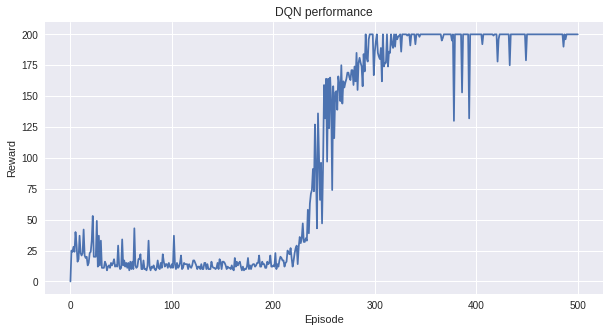

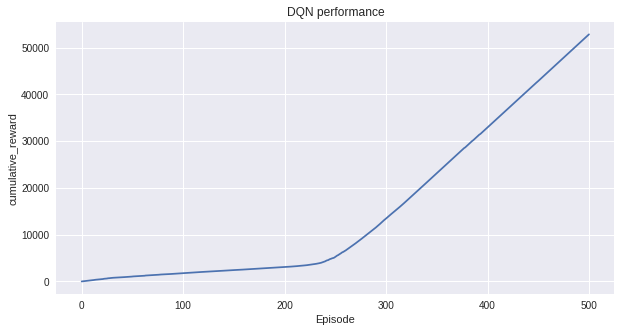

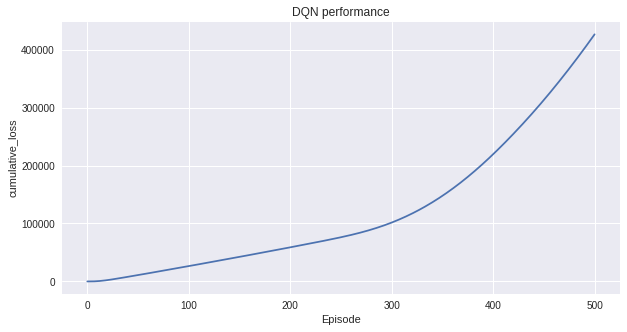

avg_r 105.722
avg_loss 120400.77617967292


In [0]:
agent = DDQN_agent(num_actions, obs_size, nhidden,
                   epoch, 
                   epsilon, gamma, learning_rate, 
                   replace, polyak, tau_step,
                   mem_size, minibatch_size)
run_episodes(env, agent, max_episodes)